# 02 - Evolving CartPole Controllers [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RobertTLange/evosax/blob/main/examples/02_mlp_control.ipynb)

## Installation

You will need Python 3.10 or later, and a working JAX installation. For example, you can install JAX on NVIDIA GPU with:

In [ ]:
%pip install -U "jax[cuda]"

Then, install `evosax` from PyPi:

In [ ]:
%pip install -U "evosax[examples]"

## Import

In [1]:
import jax
import matplotlib.pyplot as plt
import optax

In [2]:
seed = 0
key = jax.random.key(seed)

## Gymnax

### Instantiate CartPole environment

In [3]:
from evosax.problems import GymnaxProblem as Problem
from evosax.problems.networks import MLP, categorical_output_fn

policy = MLP(
    layer_sizes=(64, 64, 2),
    output_fn=categorical_output_fn,
)

problem = Problem(
    env_name="CartPole-v1",
    policy=policy,
    episode_length=200,
    num_rollouts=16,
)

key, subkey = jax.random.split(key)
solution = problem.sample(subkey)

In [11]:
print(f"Number of pararmeters: {sum(leaf.size for leaf in jax.tree.leaves(solution))}")

Number of pararmeters: 4610


### Instantiate SNES

In [12]:
from evosax.algorithms import SNES as ES

es = ES(
    population_size=128,
    solution=solution,
    optimizer=optax.adam(learning_rate=0.01),
)

params = es.default_params

### Run

In [13]:
def step(carry, key):
    state, params = carry
    key_ask, key_eval, key_tell = jax.random.split(key, 3)

    population, state = es.ask(key_ask, state, params)

    fitness, _ = problem.eval(key_eval, population)

    state, metrics = es.tell(
        key_tell, population, -fitness, state, params
    )  # Minimize fitness

    return (state, params), metrics

In [14]:
num_generations = 64

key, subkey = jax.random.split(key)
state = es.init(subkey, solution, params)

key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num_generations)
_, metrics = jax.lax.scan(
    step,
    (state, params),
    keys,
)

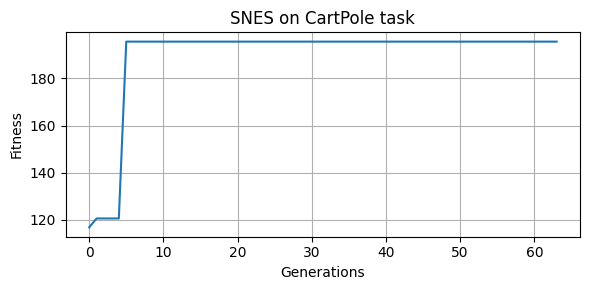

In [17]:
plt.figure(figsize=(6, 3))
plt.plot(-metrics["best_fitness"])

plt.title("SNES on CartPole task")
plt.xlabel("Generations")
plt.ylabel("Fitness")

plt.grid(True)
plt.tight_layout()

plt.show()

## Brax

### Instantiate Ant environment

In [3]:
from evosax.problems import BraxProblem as Problem
from evosax.problems.networks import MLP, tanh_output_fn

policy = MLP(
    layer_sizes=(64, 64, 8),
    output_fn=tanh_output_fn,
)

problem = Problem(
    env_name="ant",
    policy=policy,
    episode_length=200,
    num_rollouts=1,
)

key, subkey = jax.random.split(key)
solution = problem.sample(subkey)

In [4]:
print(f"Number of pararmeters: {sum(leaf.size for leaf in jax.tree.leaves(solution))}")

Number of pararmeters: 6472


### Instantiate SNES

In [5]:
from evosax.algorithms import SNES as ES

es = ES(
    population_size=1024,
    solution=solution,
    # optimizer=optax.adam(learning_rate=0.01),
)

params = es.default_params

### Run

In [6]:
def step(carry, key):
    state, params = carry
    key_ask, key_eval, key_tell = jax.random.split(key, 3)

    population, state = es.ask(key_ask, state, params)

    fitness, _ = problem.eval(key_eval, population)

    state, metrics = es.tell(
        key_tell, population, -fitness, state, params
    )  # Minimize fitness

    return (state, params), metrics

In [17]:
num_generations = 2048

key, subkey = jax.random.split(key)
state = es.init(subkey, solution, params)

key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num_generations)
(state, params), metrics = jax.lax.scan(
    step,
    (state, params),
    keys,
)

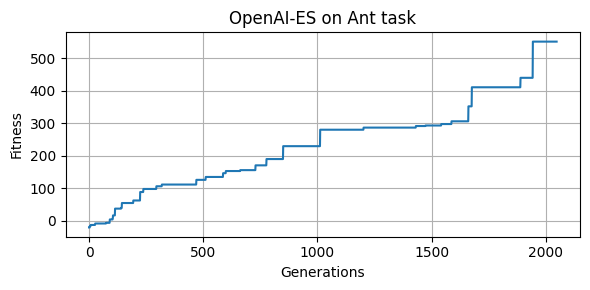

In [18]:
plt.figure(figsize=(6, 3))
plt.plot(-metrics["best_fitness"])

plt.title("OpenAI-ES on Ant task")
plt.xlabel("Generations")
plt.ylabel("Fitness")

plt.grid(True)
plt.tight_layout()

plt.show()

## Visualize policy

In [25]:
mean = es.get_mean(state)

key, subkey = jax.random.split(key)
fitness, info = problem.eval(key, jax.tree.map(lambda x: x[None], mean))
fitness

Array([-13.513492], dtype=float32)

In [26]:
from brax.io import html
from IPython.display import HTML

rollout = [jax.tree_util.tree_map(lambda x: x[0, 0, t], info.pipeline_state) for t in range(200)]
HTML(html.render(problem.env.sys.tree_replace({'opt.timestep': problem.env.dt}), rollout))

In [27]:
# Save the HTML visualization to a file
html_content = html.render(problem.env.sys.tree_replace({'opt.timestep': problem.env.dt}), rollout)

# Write to file
with open('ant_visualization.html', 'w') as f:
    f.write(html_content)

print("Visualization saved to 'ant_visualization.html'")


Visualization saved to 'ant_visualization.html'
